#### Import data set

In [1]:
import datatable as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

df = dt.fread('tripadvisor_hotel_reviews.csv').to_pandas()
# df = df.sample(frac=0.001)
df.columns = df.columns.str.lower()

#### Cleaning, lemmatizing, and removing stop words

In [20]:
import re
import spacy


def clean_text(text):
    nlp = spacy.load('en_core_web_sm')
    stopwords = nlp.Defaults.stop_words
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\bnt\b', 'not', text)
    text = re.sub(r'\\s{2,}', r'\.', text)
    text = text.strip()
    text = ' '.join(token.lemma_.lower() for token in nlp(text) if token.lemma_.lower() not in stopwords)
    return text


# Use vectorization
df['review'] = np.vectorize(clean_text)(df['review'])

# Add a column length of review 
df['review_length'] = df['review'].map(len)

In [21]:
import pickle

with open('cleaned reviews.pkl', 'wb') as f:
    pickle.dump(df['review'].values, f)

#### Get ngrams tokens

In [40]:
from textblob import TextBlob
from nltk.util import ngrams

with open('cleaned reviews.pkl', 'rb') as f:
    reviews = pickle.load(f)
reviews = ' '.join(reviews)
uni_gram_tokens = (word[0] for word in TextBlob(reviews).ngrams(1) if word[0].isalpha())
bi_gram_tokens = (word[0] for word in TextBlob(reviews).ngrams(2) if word[0].isalpha())
tri_gram_tokens = (word[0] for word in TextBlob(reviews).ngrams(3) if word[0].isalpha())

In [43]:
from collections import Counter

uni_most_commons = Counter(uni_gram_tokens).most_common(20)
bi_most_commons = Counter(bi_gram_tokens).most_common(20)
tri_most_commons = Counter(tri_gram_tokens).most_common(20)

In [48]:
def to_df(c):
    return pd.DataFrame(data=c, columns=['token', 'frequency'])

uni_most_commons = to_df(uni_most_commons)
bi_most_commons = to_df(bi_most_commons)
tri_most_commons = to_df(tri_most_commons)

<AxesSubplot:xlabel='token', ylabel='frequency'>

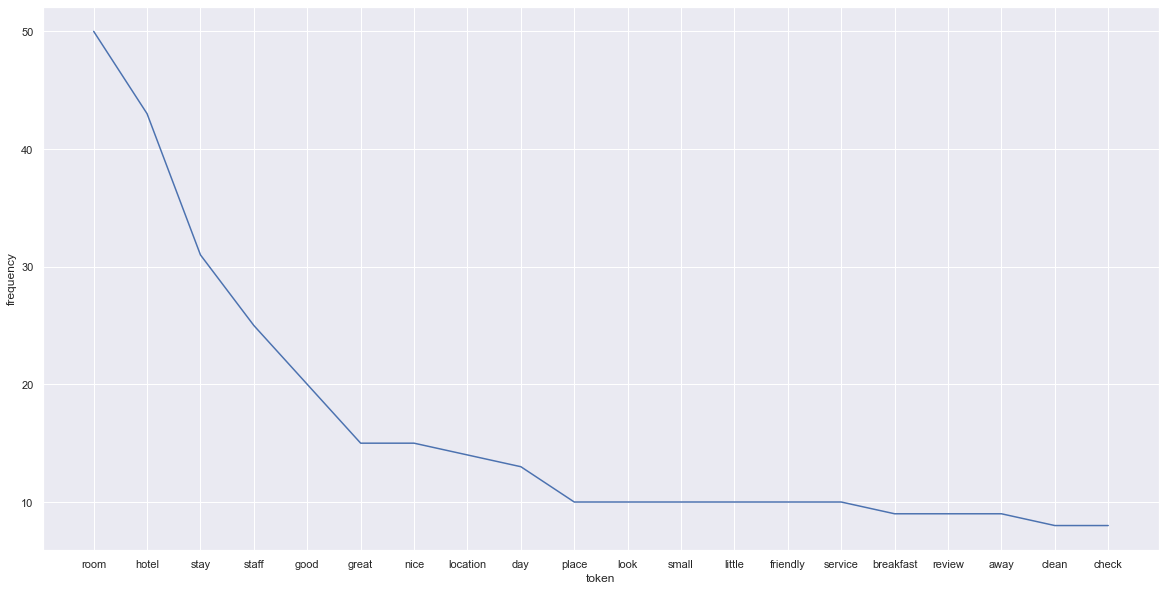

In [53]:
sb.set(rc={"figure.figsize":(20, 10)})
sb.lineplot(data=uni_most_commons, x='token', y='frequency').set(title='Most common unigrams')

In [ ]:
sb.set(rc={"figure.figsize":(20, 10)})
sb.lineplot(data=bi_most_commons, x='token', y='frequency').set(title='Most common bigrams')

In [ ]:
sb.set(rc={"figure.figsize":(20, 10)})
sb.lineplot(data=tri_most_commons, x='token', y='frequency').set(title='Most common trigrams')

In [26]:
import plotly.express as px
import cufflinks as cf

# This is to use iplot functions based on pandas
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

fig1 = df['review_length'].iplot(kind='hist', color='aqua', xTitle='Review length', yTitle='Frequency',
                                 title='Review length and Frequency')

In [27]:
fig2 = px.box(df, y="review_length", color="rating", title='Review length with ratings')
fig2.show()

In [28]:
# Create a table of review length associated with different ratings
df.groupby(by=['rating']).describe()

review_length                                                       \
               count        mean         std    min    25%    50%     75%   
rating                                                                      
1                2.0  720.000000  354.967604  469.0  594.5  720.0   845.5   
2                1.0  500.000000         NaN  500.0  500.0  500.0   500.0   
3                5.0  349.200000  268.203654  113.0  117.0  253.0   563.0   
4                3.0  478.666667  285.535170  149.0  394.0  639.0   643.5   
5                9.0  646.111111  596.874871  135.0  188.0  393.0  1039.0   

                
           max  
rating          
1        971.0  
2        500.0  
3        700.0  
4        648.0  
5       1942.0

In [ ]:
criteria = ['internet', 'breakfast', 'pillow', 'parking', 'gym', 'aroma', 'humidifier', 'keyless', 'dryer',
            'television', 'outlet']
with open('nouns.txt', 'r', encoding="utf8") as f:
    nouns = f.read()
nouns = nouns.split()

In [ ]:
import spacy

# Add nouns to importances if their similarity is close to hotel's criteria to find their importance
THRESHOLD = 0.3
nlp = spacy.load("en_core_web_sm")
importances = dict()
for noun in nouns:
    doc1 = nlp(noun)
    for criterion in criteria:
        doc2 = nlp(criterion)
        if doc1.similarity(doc2) >= THRESHOLD:
            if noun in importances:
                importances[criterion] += 1
            else:
                importances[criterion] = 1

In [ ]:
# Get the importance ratios
total = sum(value for value in importances.values())
for k, v in importances.items():
    importances[k] = v / total

In [ ]:
# write the importances to file
import json

with open('importances.txt', 'w') as file:
    file.write(json.dumps(importances))